## Cifar-10 Image Classification

Mohammed Fahmidur Rahman

### Task 1: Load CIFAR-10 Dataset and Create Data Loaders

In [1]:
# Importing necessary libraries
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

In [2]:
# Data augmentation and normalisation

# Training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Test set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
# Loading datasets and creating dataloaders
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:02<00:00, 63.2MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Defining class names for CIFAR-10 labels and testing
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

image, label = trainset[0]
print(f"Label: {label} - Class: {class_names[label]}")

Label: 6 - Class: frog


### Task 2: Create the Model

In [5]:
# STEM layer - convolutional layer to extract feature representation
class Stem(nn.Module):
    def __init__(self, out_channels=64):
        super(Stem, self).__init__()
        self.conv = nn.Conv2d(3, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [6]:
# Expert Branch - generates adaptive weights for K convolutions
class ExpertBranch(nn.Module):
    def __init__(self, in_channels, k=4, reduction=16, dropout=0.3):
        super(ExpertBranch, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(in_channels // reduction, k)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        B, C, _, _ = x.shape
        x = self.avgpool(x).view(B, C)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        a = self.softmax(x)
        return a

In [7]:
# Backbone Block - uses expert branch to weight and combine K parallel convolution outputs
class BackboneBlock(nn.Module):
    def __init__(self, channels, k=4, reduction=16, downsample=False):
        super(BackboneBlock, self).__init__()
        self.k = k
        self.expert = ExpertBranch(channels, k, reduction) # predicts weights for combining K conv paths

        stride = 2 if downsample else 1
        self.branches = nn.ModuleList()

        for _ in range(k):
            branch = nn.Sequential(
                nn.Conv2d(channels, channels, kernel_size=3, padding=1, stride=stride),
                nn.BatchNorm2d(channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=0.2)
            )
            # initialising convolutional weights
            nn.init.kaiming_normal_(branch[0].weight, mode='fan_in', nonlinearity='relu')
            nn.init.constant_(branch[0].bias, 0.0)
            self.branches.append(branch)

        self.downsample = downsample

    def forward(self, x):
        a = self.expert(x)
        branch_outputs = [branch(x) for branch in self.branches] # Appling each convolutional branch to input
        out = sum(a[:, i].view(-1, 1, 1, 1) * branch_outputs[i] for i in range(self.k))

        # Residual connection (identity or downsampled input)
        if self.downsample:
            res = F.avg_pool2d(x, kernel_size=2)
        else:
            res = x

        if res.shape != out.shape:
            # Incase the shapes differ due to the convolutional stride
            res = F.interpolate(res, size=out.shape[2:], mode='nearest')

        return out + res # Add residual connection to output

In [8]:
# Full Backbone Module - sequential stack of backbone blocks
class Backbone(nn.Module):
    def __init__(self, channels=64, num_blocks=6, k=4, reduction=16):
        super(Backbone, self).__init__()
        blocks = [BackboneBlock(channels, k, reduction, downsample=(i == 1)) for i in range(num_blocks)]
        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        return self.blocks(x)

In [9]:
# Classifier - averages each feature map to a single value, then predicts class scores with a linear layer
class Classifier(nn.Module):
    def __init__(self, in_channels=64, num_classes=10):
        super(Classifier, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [10]:
# Full Model - STEM to Backbone to Classifier
class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        self.stem = Stem(out_channels=64)
        self.backbone = Backbone(channels=64, num_blocks=6, k=4, reduction=16)
        self.classifier = Classifier(in_channels=64)

    def forward(self, x):
        x = self.stem(x)
        x = self.backbone(x)
        x = self.classifier(x)
        return x

### Task 3: Create the Loss and Optimiser

In [11]:
# Initialisation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CIFAR10Model().to(device)

# Defining Loss function and Optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.RMSprop(model.parameters(), lr=0.0008, weight_decay=5e-4)

# Learning rate scheduler - halves learning rate every 30 epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimiser, T_max=100, eta_min=1e-6)

### Task 4: Training Script

In [12]:
# Accuracy evaluation helper
@torch.no_grad() # Disabling the gradient calculation
def evaluate(model, dataloader):
    model.eval() # setting model to evaluation mode
    total, correct = 0, 0
    running_loss = 0 # accumulating the total loss across the batches

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = loss_fn(out, y)  # compute val loss
        preds = out.argmax(dim=1)

        correct += (preds == y).sum().item()
        total += y.size(0)
        running_loss += loss.item() * y.size(0) # accumulate the weighted loss

    val_acc = 100 * correct / total # final accuracy
    val_loss = running_loss / total # final average loss
    return val_acc, val_loss

# Training loop for model
def train(model, trainloader, testloader, epochs=85):
    history = { # dictionary to store loss and accuracy after each epoch
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(epochs): # iterating through training data
        model.train()
        running_loss, correct, total = 0, 0, 0

        for x, y in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}"):
            x, y = x.to(device), y.to(device)
            optimiser.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            optimiser.step()

            running_loss += loss.item() * y.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        scheduler.step()
        train_loss = running_loss / total
        train_acc = 100 * correct / total
        val_acc, val_loss = evaluate(model, testloader) # evaluate on the test set

        # saving training metrics to history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # Printing the results
        print(f"Loss: {train_loss:.4f}  Train Acc: {train_acc:.2f}%  Val Acc: {val_acc:.2f}%")

    return history

In [13]:
# Run training for 85 epochs
history = train(model, trainloader, testloader, epochs=85)

Epoch 1/85: 100%|██████████| 391/391 [00:35<00:00, 11.04it/s]


Loss: 1.8367  Train Acc: 32.45%  Val Acc: 27.26%


Epoch 2/85: 100%|██████████| 391/391 [00:34<00:00, 11.40it/s]


Loss: 1.5250  Train Acc: 43.92%  Val Acc: 41.74%


Epoch 3/85: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s]


Loss: 1.4272  Train Acc: 47.75%  Val Acc: 52.63%


Epoch 4/85: 100%|██████████| 391/391 [00:34<00:00, 11.44it/s]


Loss: 1.3506  Train Acc: 50.79%  Val Acc: 45.50%


Epoch 5/85: 100%|██████████| 391/391 [00:34<00:00, 11.43it/s]


Loss: 1.2954  Train Acc: 53.38%  Val Acc: 41.57%


Epoch 6/85: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s]


Loss: 1.2453  Train Acc: 55.23%  Val Acc: 51.31%


Epoch 7/85: 100%|██████████| 391/391 [00:34<00:00, 11.43it/s]


Loss: 1.1992  Train Acc: 57.23%  Val Acc: 56.12%


Epoch 8/85: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s]


Loss: 1.1652  Train Acc: 58.16%  Val Acc: 54.62%


Epoch 9/85: 100%|██████████| 391/391 [00:34<00:00, 11.39it/s]


Loss: 1.1254  Train Acc: 59.77%  Val Acc: 43.41%


Epoch 10/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 1.0920  Train Acc: 61.15%  Val Acc: 51.00%


Epoch 11/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 1.0671  Train Acc: 61.80%  Val Acc: 53.93%


Epoch 12/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 1.0416  Train Acc: 62.97%  Val Acc: 58.95%


Epoch 13/85: 100%|██████████| 391/391 [00:34<00:00, 11.45it/s]


Loss: 1.0177  Train Acc: 64.05%  Val Acc: 45.53%


Epoch 14/85: 100%|██████████| 391/391 [00:34<00:00, 11.44it/s]


Loss: 0.9945  Train Acc: 64.98%  Val Acc: 58.13%


Epoch 15/85: 100%|██████████| 391/391 [00:34<00:00, 11.45it/s]


Loss: 0.9749  Train Acc: 65.90%  Val Acc: 62.35%


Epoch 16/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.9490  Train Acc: 66.64%  Val Acc: 61.43%


Epoch 17/85: 100%|██████████| 391/391 [00:34<00:00, 11.46it/s]


Loss: 0.9264  Train Acc: 67.65%  Val Acc: 57.42%


Epoch 18/85: 100%|██████████| 391/391 [00:34<00:00, 11.46it/s]


Loss: 0.9081  Train Acc: 68.16%  Val Acc: 51.28%


Epoch 19/85: 100%|██████████| 391/391 [00:34<00:00, 11.46it/s]


Loss: 0.8912  Train Acc: 69.24%  Val Acc: 62.92%


Epoch 20/85: 100%|██████████| 391/391 [00:34<00:00, 11.45it/s]


Loss: 0.8715  Train Acc: 69.87%  Val Acc: 67.55%


Epoch 21/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.8545  Train Acc: 70.58%  Val Acc: 65.93%


Epoch 22/85: 100%|██████████| 391/391 [00:34<00:00, 11.45it/s]


Loss: 0.8339  Train Acc: 71.37%  Val Acc: 70.17%


Epoch 23/85: 100%|██████████| 391/391 [00:34<00:00, 11.45it/s]


Loss: 0.8090  Train Acc: 72.52%  Val Acc: 73.32%


Epoch 24/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.7970  Train Acc: 72.83%  Val Acc: 70.20%


Epoch 25/85: 100%|██████████| 391/391 [00:34<00:00, 11.46it/s]


Loss: 0.7853  Train Acc: 73.44%  Val Acc: 68.94%


Epoch 26/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.7677  Train Acc: 73.95%  Val Acc: 69.05%


Epoch 27/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.7511  Train Acc: 74.63%  Val Acc: 74.89%


Epoch 28/85: 100%|██████████| 391/391 [00:34<00:00, 11.44it/s]


Loss: 0.7352  Train Acc: 75.26%  Val Acc: 73.43%


Epoch 29/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.7247  Train Acc: 75.72%  Val Acc: 67.89%


Epoch 30/85: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]


Loss: 0.7138  Train Acc: 76.07%  Val Acc: 67.33%


Epoch 31/85: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]


Loss: 0.7004  Train Acc: 76.52%  Val Acc: 74.80%


Epoch 32/85: 100%|██████████| 391/391 [00:34<00:00, 11.45it/s]


Loss: 0.6898  Train Acc: 77.05%  Val Acc: 76.89%


Epoch 33/85: 100%|██████████| 391/391 [00:33<00:00, 11.51it/s]


Loss: 0.6710  Train Acc: 77.74%  Val Acc: 79.26%


Epoch 34/85: 100%|██████████| 391/391 [00:34<00:00, 11.50it/s]


Loss: 0.6666  Train Acc: 77.55%  Val Acc: 79.29%


Epoch 35/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.6553  Train Acc: 78.28%  Val Acc: 79.23%


Epoch 36/85: 100%|██████████| 391/391 [00:34<00:00, 11.48it/s]


Loss: 0.6461  Train Acc: 78.55%  Val Acc: 73.73%


Epoch 37/85: 100%|██████████| 391/391 [00:34<00:00, 11.50it/s]


Loss: 0.6365  Train Acc: 78.76%  Val Acc: 77.67%


Epoch 38/85: 100%|██████████| 391/391 [00:33<00:00, 11.51it/s]


Loss: 0.6254  Train Acc: 79.25%  Val Acc: 68.86%


Epoch 39/85: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]


Loss: 0.6224  Train Acc: 79.60%  Val Acc: 79.71%


Epoch 40/85: 100%|██████████| 391/391 [00:34<00:00, 11.50it/s]


Loss: 0.6113  Train Acc: 79.76%  Val Acc: 79.78%


Epoch 41/85: 100%|██████████| 391/391 [00:34<00:00, 11.48it/s]


Loss: 0.6016  Train Acc: 80.03%  Val Acc: 81.65%


Epoch 42/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.5947  Train Acc: 80.24%  Val Acc: 80.08%


Epoch 43/85: 100%|██████████| 391/391 [00:34<00:00, 11.46it/s]


Loss: 0.5852  Train Acc: 80.63%  Val Acc: 83.12%


Epoch 44/85: 100%|██████████| 391/391 [00:34<00:00, 11.48it/s]


Loss: 0.5804  Train Acc: 81.05%  Val Acc: 77.33%


Epoch 45/85: 100%|██████████| 391/391 [00:34<00:00, 11.44it/s]


Loss: 0.5726  Train Acc: 80.99%  Val Acc: 69.53%


Epoch 46/85: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]


Loss: 0.5599  Train Acc: 81.70%  Val Acc: 77.74%


Epoch 47/85: 100%|██████████| 391/391 [00:34<00:00, 11.46it/s]


Loss: 0.5549  Train Acc: 81.51%  Val Acc: 84.39%


Epoch 48/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.5464  Train Acc: 81.98%  Val Acc: 83.23%


Epoch 49/85: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]


Loss: 0.5360  Train Acc: 82.34%  Val Acc: 74.14%


Epoch 50/85: 100%|██████████| 391/391 [00:34<00:00, 11.50it/s]


Loss: 0.5307  Train Acc: 82.46%  Val Acc: 79.20%


Epoch 51/85: 100%|██████████| 391/391 [00:34<00:00, 11.48it/s]


Loss: 0.5213  Train Acc: 82.88%  Val Acc: 79.00%


Epoch 52/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.5213  Train Acc: 82.82%  Val Acc: 84.19%


Epoch 53/85: 100%|██████████| 391/391 [00:34<00:00, 11.48it/s]


Loss: 0.5081  Train Acc: 83.17%  Val Acc: 82.75%


Epoch 54/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.5041  Train Acc: 83.43%  Val Acc: 82.94%


Epoch 55/85: 100%|██████████| 391/391 [00:34<00:00, 11.50it/s]


Loss: 0.4981  Train Acc: 83.57%  Val Acc: 82.24%


Epoch 56/85: 100%|██████████| 391/391 [00:34<00:00, 11.48it/s]


Loss: 0.4940  Train Acc: 83.75%  Val Acc: 81.70%


Epoch 57/85: 100%|██████████| 391/391 [00:34<00:00, 11.48it/s]


Loss: 0.4902  Train Acc: 83.89%  Val Acc: 77.75%


Epoch 58/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.4775  Train Acc: 84.47%  Val Acc: 84.05%


Epoch 59/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.4719  Train Acc: 84.43%  Val Acc: 86.02%


Epoch 60/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.4662  Train Acc: 84.71%  Val Acc: 85.44%


Epoch 61/85: 100%|██████████| 391/391 [00:34<00:00, 11.46it/s]


Loss: 0.4586  Train Acc: 84.75%  Val Acc: 86.07%


Epoch 62/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.4535  Train Acc: 84.98%  Val Acc: 85.90%


Epoch 63/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.4434  Train Acc: 85.57%  Val Acc: 86.88%


Epoch 64/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.4415  Train Acc: 85.51%  Val Acc: 85.28%


Epoch 65/85: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]


Loss: 0.4344  Train Acc: 85.80%  Val Acc: 87.38%


Epoch 66/85: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]


Loss: 0.4262  Train Acc: 85.96%  Val Acc: 85.37%


Epoch 67/85: 100%|██████████| 391/391 [00:34<00:00, 11.46it/s]


Loss: 0.4231  Train Acc: 86.06%  Val Acc: 86.48%


Epoch 68/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.4137  Train Acc: 86.33%  Val Acc: 87.04%


Epoch 69/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.4104  Train Acc: 86.51%  Val Acc: 86.33%


Epoch 70/85: 100%|██████████| 391/391 [00:34<00:00, 11.46it/s]


Loss: 0.4016  Train Acc: 86.85%  Val Acc: 87.13%


Epoch 71/85: 100%|██████████| 391/391 [00:34<00:00, 11.48it/s]


Loss: 0.3991  Train Acc: 86.99%  Val Acc: 87.53%


Epoch 72/85: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]


Loss: 0.3936  Train Acc: 87.16%  Val Acc: 85.68%


Epoch 73/85: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]


Loss: 0.3872  Train Acc: 87.27%  Val Acc: 86.72%


Epoch 74/85: 100%|██████████| 391/391 [00:34<00:00, 11.48it/s]


Loss: 0.3823  Train Acc: 87.57%  Val Acc: 88.52%


Epoch 75/85: 100%|██████████| 391/391 [00:34<00:00, 11.50it/s]


Loss: 0.3756  Train Acc: 87.86%  Val Acc: 88.41%


Epoch 76/85: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]


Loss: 0.3727  Train Acc: 87.79%  Val Acc: 88.44%


Epoch 77/85: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]


Loss: 0.3648  Train Acc: 88.14%  Val Acc: 88.40%


Epoch 78/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.3606  Train Acc: 88.14%  Val Acc: 88.73%


Epoch 79/85: 100%|██████████| 391/391 [00:34<00:00, 11.46it/s]


Loss: 0.3582  Train Acc: 88.29%  Val Acc: 88.92%


Epoch 80/85: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]


Loss: 0.3490  Train Acc: 88.73%  Val Acc: 89.10%


Epoch 81/85: 100%|██████████| 391/391 [00:34<00:00, 11.48it/s]


Loss: 0.3494  Train Acc: 88.72%  Val Acc: 88.89%


Epoch 82/85: 100%|██████████| 391/391 [00:34<00:00, 11.50it/s]


Loss: 0.3390  Train Acc: 88.98%  Val Acc: 89.10%


Epoch 83/85: 100%|██████████| 391/391 [00:34<00:00, 11.48it/s]


Loss: 0.3365  Train Acc: 89.01%  Val Acc: 89.14%


Epoch 84/85: 100%|██████████| 391/391 [00:34<00:00, 11.45it/s]


Loss: 0.3316  Train Acc: 89.22%  Val Acc: 89.45%


Epoch 85/85: 100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Loss: 0.3299  Train Acc: 89.34%  Val Acc: 89.13%


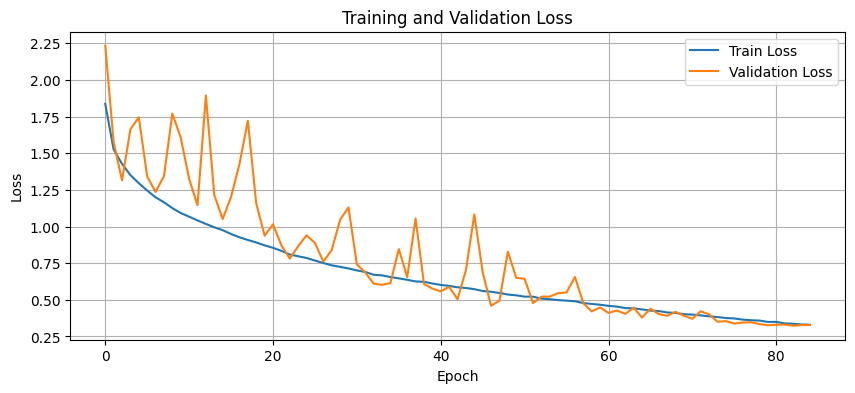

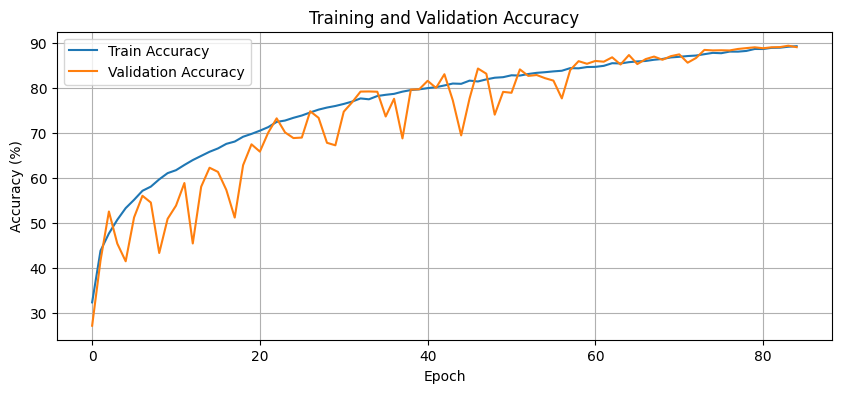

In [14]:
# Plotting the graphs
import matplotlib.pyplot as plt

# Plot training vs validation loss
plt.figure(figsize=(10, 4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot training vs validation accuracy
plt.figure(figsize=(10, 4))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Saving the trained model to a file
torch.save(model.state_dict(), "cifar10_model_final.pth")
print("Model saved as cifar10_model_final.pth")

Model saved as cifar10_model_final.pth


### Task 5: Final Model Accuracy

In [16]:
print(f"Final Training Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Final Validation Accuracy: {history['val_acc'][-1]:.2f}%")

Final Training Accuracy: 89.34%
Final Validation Accuracy: 89.13%
